# Copernicus Climate Data Store (CDS) access using xcube

Before using this notebook, ensure that you have set up xcube, the CDS plugin, and Jupyter Lab as described in the [Ex0-CDS-Setup](./Ex0-CDS-Setup.ipynb) notebook.

Import some necessary libraries.

In [1]:
# xcube_cds imports
from xcube_cds.store import CDSDataStore

# xcube imports
import xcube
from xcube.core.dsio import write_cube
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import time
import zarr

Display graphs inline directly in the notebook.

In [2]:
%matplotlib inline

Define the bounding box for the area of interest. For this example, we will be using the mid-latitudes of Europe.

In [25]:
w = -10  # degree
s = 45   # degree
e = 40   # degree
n = 65   # degree

bbox = [n, w, s, e]

Plot the bounding box on a map to check that we have the correct area.

In [6]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Define the desired spatial resolution. ERA5 data are available at a maximum resolution of 0.25°, so this is what we specify.

In [7]:
spatial_res = 0.25

Create a data store object. The `normalize_names` parameter specifies that variable names will be converted to legal Python identifiers, if required.

In [9]:
cds_store = CDSDataStore(normalize_names=True)

In [10]:
openers = cds_store.get_data_opener_ids()

In [11]:
openers

('dataset:netcdf:cds',)

In [12]:
opener = openers[0]

In [26]:
cube = cds_store.open_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis',
                           opener,
                           variable_names=['2m_temperature'],
                           bbox=bbox,
                           spatial_res=spatial_res,
                           time_range=['2001-01-01', '2010-12-31'],
                           time_period='1M')

2020-06-29 15:22:09,398 INFO Welcome to the CDS
2020-06-29 15:22:09,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2020-06-29 15:22:10,085 INFO Request is queued
2020-06-29 15:22:11,276 INFO Request is running
2020-06-29 15:23:00,421 INFO Request is completed
2020-06-29 15:23:00,423 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data3/adaptor.mars.internal-1593436930.8307824-18170-19-64c224a4-5485-4d0e-8799-799c0b32257c.nc to /tmp/tmperovtlg3/tmp8zmy04c_/data.nc (3.7M)
2020-06-29 15:23:09,353 INFO Download rate 427.6K/s 


In [27]:
cube

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 201, time: 120)
Coordinates:
  * lon      (lon) float32 -10.0 -9.75 -9.5 -9.25 -9.0 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float32 65.0 64.75 64.5 64.25 64.0 ... 45.75 45.5 45.25 45.0
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2010-12-01
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-29 13:22:47 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

Plot the differences between successive time points in the dataset. We can see that the times are monotonically increasing (all the difference values are positive), but not equally spaced, since months are not all of the same length. The lowest values correspond to February; the four-year leap year cycle can also be discerned.

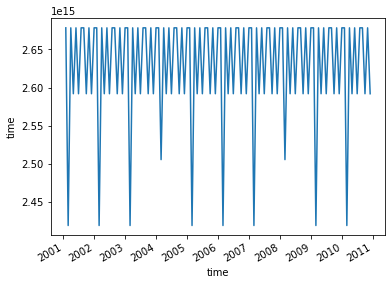

In [62]:
cube.time.diff(dim='time').plot.line()

In [ ]:
cube.time.diff(dim='time').plot

In [65]:
jan_2001 = cube.t2m.sel(time='2001-01-01 00:00:00', method='nearest')

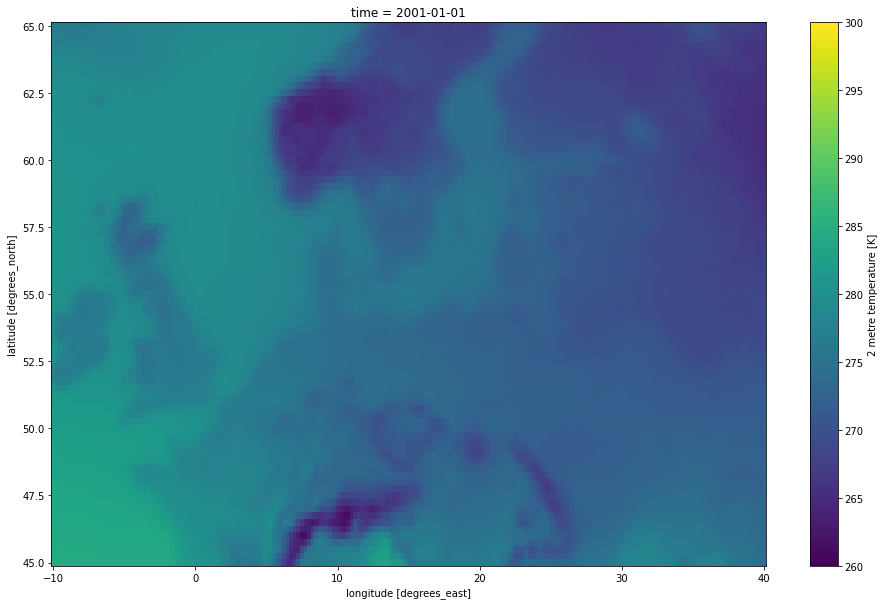

In [66]:
jan_2001.plot.imshow(vmin=260, vmax=300, figsize=(16, 10))

In [69]:
jun_2001 = cube.t2m.sel(time='2001-06-01 00:00:00', method='nearest')

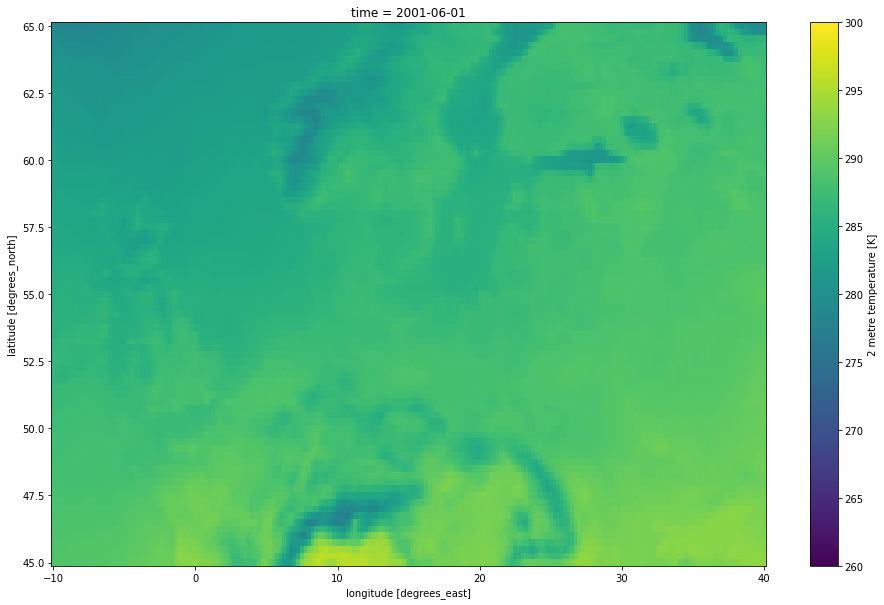

In [70]:
jun_2001.plot.imshow(vmin=260, vmax=300, figsize=(16, 10))

<xarray.DataArray 't2m' (lat: 81, lon: 201)>
array([[ 2.256256 ,  2.2917786,  2.322876 , ..., 12.065735 , 12.773926 ,
        13.493225 ],
       [ 2.3073425,  2.3036194,  2.2999268, ..., 13.2682495, 13.637512 ,
        13.979401 ],
       [ 2.288086 ,  2.291809 ,  2.2955017, ..., 19.156464 , 19.442108 ,
        19.7211   ],
       ...,
       [ 4.5924683,  4.5554504,  4.582855 , ..., 18.54892  , 18.74649  ,
        18.91153  ],
       [ 4.523651 ,  4.495514 ,  4.528076 , ..., 18.666595 , 18.887848 ,
        19.049164 ],
       [ 4.4637146,  4.4481506,  4.463684 , ..., 18.541534 , 18.901154 ,
        19.084686 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -10.0 -9.75 -9.5 -9.25 -9.0 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float32 65.0 64.75 64.5 64.25 64.0 ... 45.75 45.5 45.25 45.0

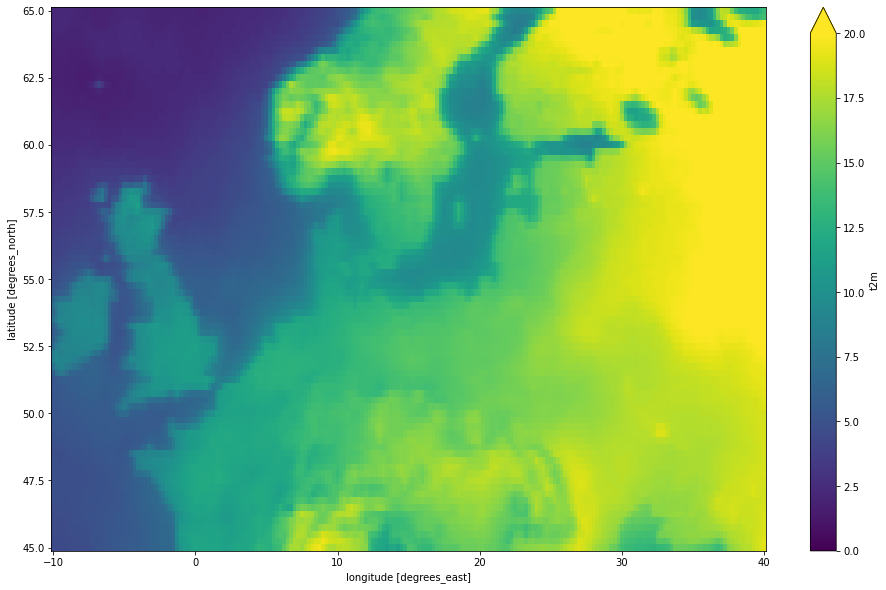

In [76]:
(jun_2001 - jan_2001).plot.imshow(vmin=0, vmax=20, figsize=(16, 10))

In [116]:
test1 = cube.t2m[6:60:12]

In [117]:
test1m = test1.mean(axis=0)

In [93]:
test1m

<xarray.DataArray 't2m' (lat: 81, lon: 201)>
array([[278.2064 , 278.1741 , 278.14093, ..., 274.25204, 274.15912,
        274.06378],
       [278.58023, 278.52805, 278.47598, ..., 274.3613 , 274.3444 ,
        274.3388 ],
       [278.98737, 278.9324 , 278.87665, ..., 275.15945, 275.19348,
        275.2262 ],
       ...,
       [287.48196, 287.4804 , 287.47855, ..., 284.93137, 284.87366,
        284.73672],
       [287.56366, 287.5616 , 287.5594 , ..., 285.20508, 285.16006,
        285.0305 ],
       [287.64954, 287.63855, 287.64297, ..., 285.38544, 285.2454 ,
        285.14047]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -10.0 -9.75 -9.5 -9.25 -9.0 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float32 65.0 64.75 64.5 64.25 64.0 ... 45.75 45.5 45.25 45.0

In [118]:
test2 = cube.t2m[66::12]

In [119]:
test2m = test2.mean(axis=0)

In [98]:
test2m

<xarray.DataArray 't2m' (lat: 81, lon: 201)>
array([[278.11383, 278.06772, 278.02048, ..., 275.16125, 275.02106,
        274.878  ],
       [278.47482, 278.40652, 278.33755, ..., 275.16367, 275.11835,
        275.08987],
       [278.87613, 278.8078 , 278.73856, ..., 275.26706, 275.29117,
        275.31497],
       ...,
       [287.3963 , 287.39813, 287.39462, ..., 285.5941 , 285.52405,
        285.35678],
       [287.48672, 287.4879 , 287.48358, ..., 285.80267, 285.74936,
        285.59402],
       [287.57605, 287.56952, 287.5709 , ..., 285.95364, 285.8166 ,
        285.69235]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -10.0 -9.75 -9.5 -9.25 -9.0 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float32 65.0 64.75 64.5 64.25 64.0 ... 45.75 45.5 45.25 45.0

In [120]:
diff = test2m - test1m

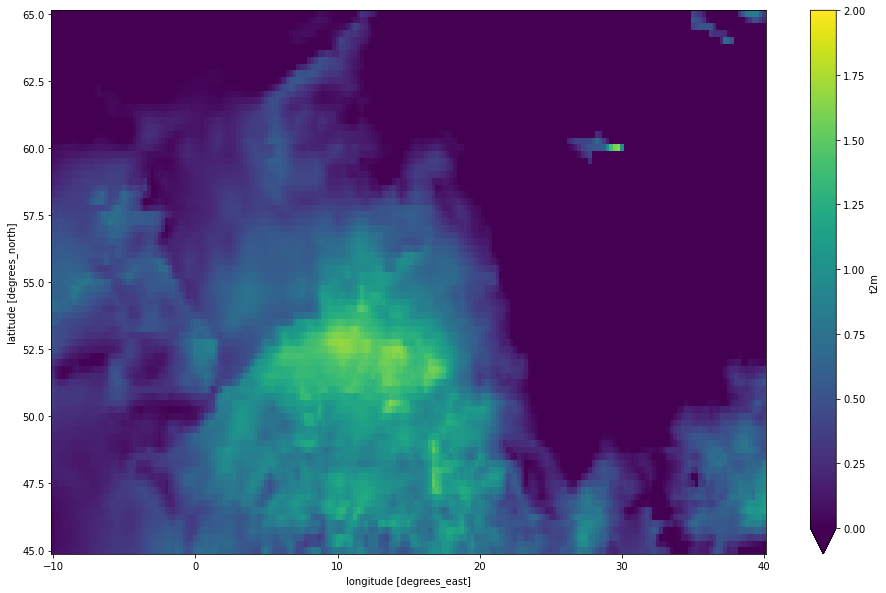

In [121]:
diff.plot.imshow(vmin=0, vmax=2, figsize=(16, 10))

<xarray.DataArray 't2m' (lat: 81, lon: 201)>
array([[-0.09255981, -0.10638428, -0.12045288, ...,  0.9092102 ,
         0.8619385 ,  0.814209  ],
       [-0.10540771, -0.121521  , -0.13842773, ...,  0.80236816,
         0.7739563 ,  0.7510681 ],
       [-0.11123657, -0.12460327, -0.13809204, ...,  0.10760498,
         0.09768677,  0.08877563],
       ...,
       [-0.08566284, -0.08227539, -0.08392334, ...,  0.6627197 ,
         0.6503906 ,  0.62005615],
       [-0.07693481, -0.07369995, -0.07580566, ...,  0.5975952 ,
         0.58929443,  0.5635376 ],
       [-0.07348633, -0.06903076, -0.07208252, ...,  0.5682068 ,
         0.5711975 ,  0.5518799 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -10.0 -9.75 -9.5 -9.25 -9.0 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float32 65.0 64.75 64.5 64.25 64.0 ... 45.75 45.5 45.25 45.0